# Movie Recommendation System Analysis

**Created by:** Rayah Mian  
**Date:** Tuesday, July 14, 2023

-------------------------------------------------------------------------

## 1. Introduction

I will leverage data from four prominent streaming platforms to develop a movie recommendation system. This system will utilize content-based filtering techniques to generate personalized recommendations based on movie attributes. Users will have the ability to specify their preferences, whether it be a specific movie genre or country of origin, enabling them to discover relevant titles within the system.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mapping import genre_mapping, rating_mapping, rating_mapping2

In [2]:
pd.set_option('display.max_rows', None)

# Initialize the data
adf = pd.read_csv('amazonprime_data.csv')
ddf = pd.read_csv('disneyplus_data.csv')
hdf = pd.read_csv('hulu_data.csv')
ndf = pd.read_csv('netflix_data.csv')

# Add the "platform" column to each DataFrame
adf['platform'] = 'Amazon Prime'
ddf['platform'] = 'Disney Plus'
hdf['platform'] = 'Hulu'
ndf['platform'] = 'Netflix'

# Modify the show IDs
adf['show_id'] = 'AP' + adf['show_id'].str[1:]
ddf['show_id'] = 'DP' + ddf['show_id'].str[1:]
hdf['show_id'] = 'H' + hdf['show_id'].str[1:]
ndf['show_id'] = 'N' + ndf['show_id'].str[1:]

# Merge all the data
df1 = pd.concat([adf, ddf, hdf, ndf], ignore_index=True)

## 2. Exploratory Data Analysis (EDA) 

### 2.1 Data Overview 

The movie recommender project utilizes data from four popular streaming platforms: Netflix, Amazon Prime, Hulu, and Disney Plus. To create a comprehensive dataset for analysis, the individual datasets from each platform were merged into one large dataset named 'df', each containing a collection of movies and TV shows with their respective attributes. By merging these datasets, we are creating a comprehensive and consolidated dataset. The purpose of this consolidation is to establish a rich foundation from which I will develop and implement the recommendation system.  

In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22998 entries, 0 to 22997
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       22998 non-null  object
 1   type          22998 non-null  object
 2   title         22998 non-null  object
 3   director      14739 non-null  object
 4   cast          17677 non-null  object
 5   country       11499 non-null  object
 6   date_added    13444 non-null  object
 7   release_year  22998 non-null  int64 
 8   rating        22134 non-null  object
 9   duration      22516 non-null  object
 10  listed_in     22998 non-null  object
 11  description   22994 non-null  object
 12  platform      22998 non-null  object
dtypes: int64(1), object(12)
memory usage: 2.3+ MB


In [4]:
# CLEAN DATA

# Merge Duplicates
columns_to_check = ['title', 'release_year']
num_duplicates = df1.duplicated(subset=columns_to_check).sum()
df_sorted = df1.sort_values(by=['title', 'release_year'])
grouped = df_sorted.groupby(['title', 'release_year'])
consolidation_rules = {
    'show_id': 'last',
    'platform': lambda x: ', '.join(x),
    'type': 'last',
    'director': 'last',
    'country': 'last',
    'cast': 'last',
    'date_added': 'last',
    'rating': 'last',
    'duration': 'last',
    'listed_in': lambda x: ', '.join(x),
    'description': 'last'}
df = grouped.agg(consolidation_rules).reset_index()

# Replace fields that have strings "nan" with a np.nan value
df.replace("nan", np.nan, inplace=True)

# Remove TV Shows from df
df = df[df['type'] == 'Movie']

# Rename the listed_in column to genre
df.rename(columns={'listed_in': 'genre'}, inplace=True)

# Reorganize the columns
column_order = ['title', 'show_id', 'type', 'platform', 'director', 'cast', 'country', 'date_added', 'release_year', 
                'rating', 'duration', 'genre', 'description']
df = df.reindex(columns=column_order)

# Only keep entries that have duration in minutes
df['duration'] = df['duration'].astype(str)
df = df[~df['duration'].str.contains('Season')]
df['duration'] = df['duration'].str.extract('(\d+)').astype(float)
df['duration'] = df['duration'].astype('Int64')

# Format the ratings
df['rating'] = df['rating'].astype(str)
df = df[~df['rating'].str.contains('Season')]
df['rating'] = df['rating'].replace(rating_mapping, regex=True)
df['rating'] = df['rating'].replace(rating_mapping2)

def remove_duplicate_genres(genre_string):
    g = genre_string.split(', ')
    ug = sorted(set(g), key=g.index)
    return ', '.join(ug)

# Format the genres
for index, row in df.iterrows():
    genres = row['genre'].split(', ')
    new_genres = [genre_mapping[genre] if genre in genre_mapping else genre for genre in genres]
    df.at[index, 'genre'] = ', '.join(new_genres)
df['genre'] = df['genre'].apply(remove_duplicate_genres)
df.reset_index(drop=True, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16103 entries, 0 to 16102
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         16103 non-null  object
 1   show_id       16103 non-null  object
 2   type          16103 non-null  object
 3   platform      16103 non-null  object
 4   director      14320 non-null  object
 5   cast          13450 non-null  object
 6   country       7726 non-null   object
 7   date_added    8517 non-null   object
 8   release_year  16103 non-null  int64 
 9   rating        14981 non-null  object
 10  duration      15714 non-null  Int64 
 11  genre         16103 non-null  object
 12  description   16100 non-null  object
dtypes: Int64(1), int64(1), object(11)
memory usage: 1.6+ MB


### 2.2 Key Statistics

The exploratory data analysis (EDA) of the movie dataset yielded valuable insights into the key characteristics and properties of movies available. Below are the key statistics for the continuous variables: release year and duration.

In [6]:
df.describe()

,release_year,duration
count,16103.000000,15714.0
mean,2009.178538,93.431335
std,17.297785,36.007902
min,1920.000000,0.0
25%,2008.000000,80.0
50%,2016.000000,94.0
75%,2019.000000,109.0
max,2021.000000,601.0


### 2.3 Visualizations

By combining these informative visualizations, we aim to present a comprehensive overview of our movie dataset. The visualizations presented in this section are categorized as follows:

1. **Box Plots**: To gain insights into the spread and central tendency of release years and durations, we present box plots. These plots offer a concise representation of the distribution's quartiles, median, and potential outliers.

2. **Histograms**: We employ histograms to portray the distribution of release years and movie durations. These graphical representations allow us to discern any patterns in movie releases over the years and explore the range of movie durations in our dataset.

3. **Bar Charts**: Bar charts are utilized to visualize the distribution of movies across different streaming platforms and genres. These visualizations provide a clear overview of the popularity of various platforms and genres within our dataset.

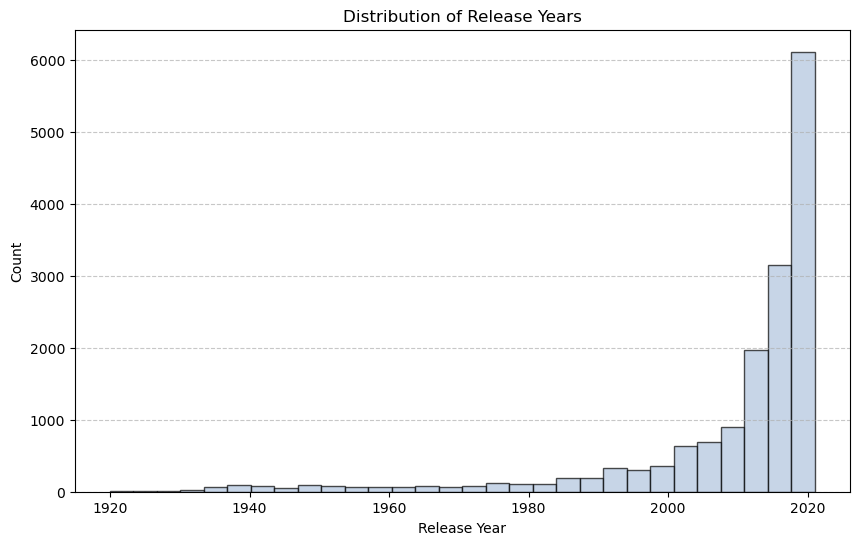

In [7]:
# Histogram for Release Year
plt.figure(figsize=(10, 6))  # Set the figure size for better visualization
plt.hist(df['release_year'], bins=30, color='lightsteelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.title('Distribution of Release Years')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

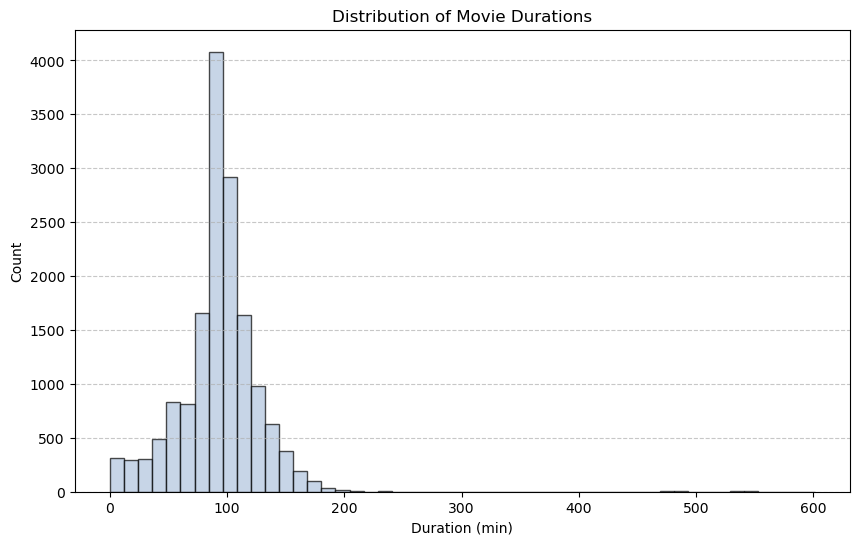

In [8]:
# Histogram for Duration
plt.figure(figsize=(10, 6))
plt.hist(df['duration'].dropna(), bins=50, color='lightsteelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Duration (min)')
plt.ylabel('Count')
plt.title('Distribution of Movie Durations')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

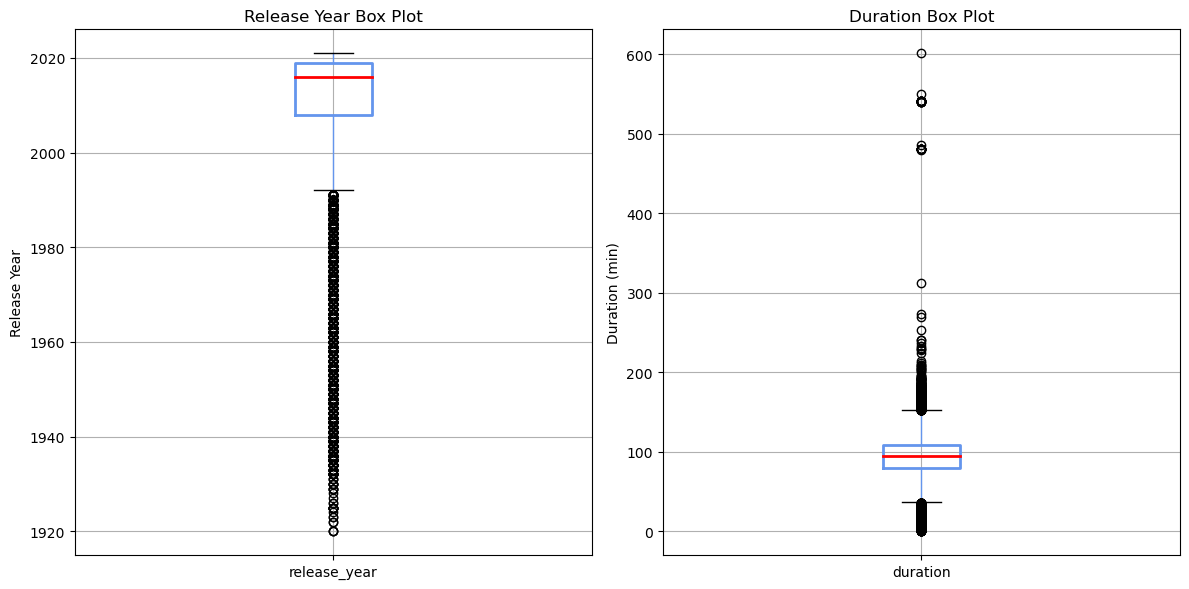

In [9]:
# Box Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Box plot for release_year
boxprops = dict(linestyle='-', linewidth=2, color='cornflowerblue')
whiskerprops = dict(linestyle='-', linewidth=1, color='cornflowerblue')
medianprops = dict(linestyle='-', linewidth=2, color='red')
df.boxplot(column='release_year', ax=axes[0], boxprops=boxprops, whiskerprops=whiskerprops, medianprops=medianprops)
axes[0].set_title('Release Year Box Plot')
axes[0].set_ylabel('Release Year')

# Box plot for duration
boxprops = dict(linestyle='-', linewidth=2, color='cornflowerblue')
whiskerprops = dict(linestyle='-', linewidth=1, color='cornflowerblue')
medianprops = dict(linestyle='-', linewidth=2, color='red')
df.boxplot(column='duration', ax=axes[1], boxprops=boxprops, whiskerprops=whiskerprops, medianprops=medianprops)
axes[1].set_title('Duration Box Plot')
axes[1].set_ylabel('Duration (min)')

# Display the plots
plt.tight_layout()
plt.show()

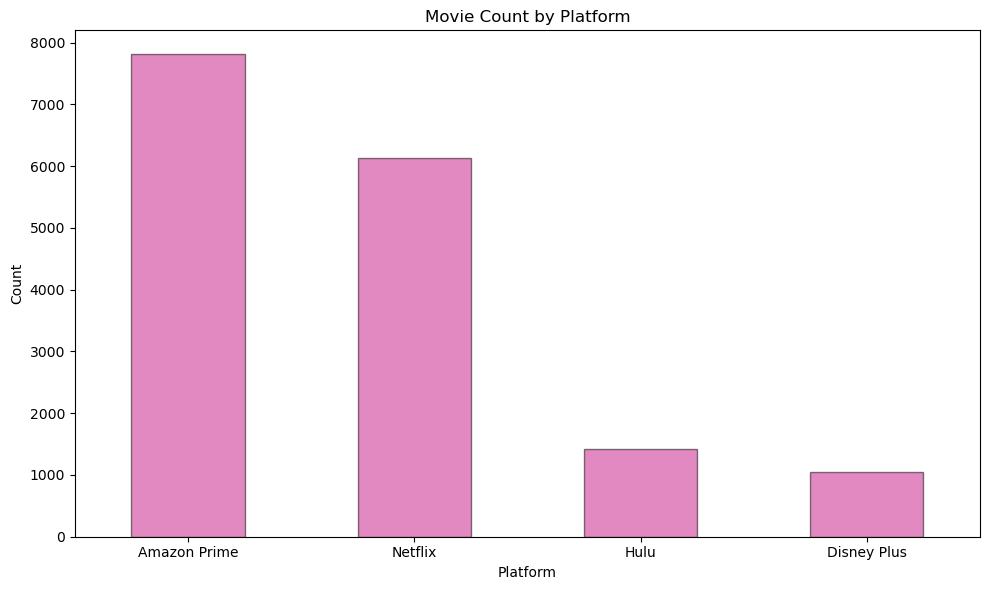

In [10]:
platform_counts = df['platform'].str.split(', ').explode().value_counts()
genre_counts = df['genre'].str.split(', ').explode().value_counts()

# Bar Chart for Platforms
plt.figure(figsize=(10, 6))

platform_counts.plot(kind='bar', color='mediumvioletred', edgecolor='black', alpha=0.5)
plt.title('Movie Count by Platform')
plt.xlabel('Platform')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

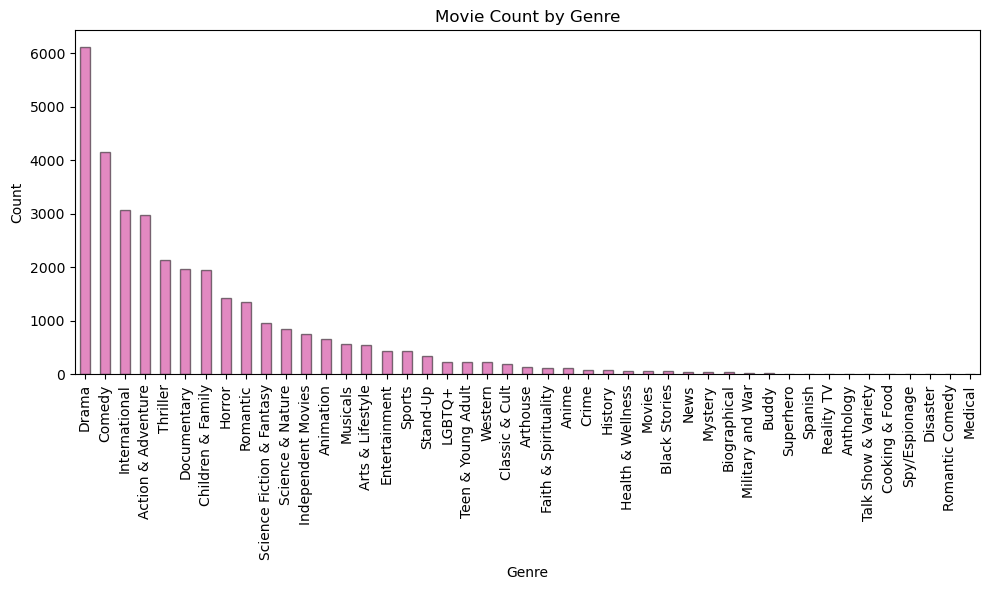

In [11]:
# Bar Chart for Genre
plt.figure(figsize=(10, 6))

genre_counts.plot(kind='bar', color='mediumvioletred', edgecolor='black', alpha=0.5)
plt.title('Movie Count by Genre')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

### 2.3 Genre Analysis

According to the bar plot of movie count by genre, we can see the most common genres in the dataset. Let’s explore the genres and their trends further.

In [12]:
# Top Genres
genre_percentages = genre_counts / len(df) * 100
top_genres = genre_percentages.head(10)
print(top_genres)

Drama                        37.992921
Comedy                       25.796435
International                19.033720
Action & Adventure           18.518289
Thriller                     13.320499
Documentary                  12.233745
Children & Family            12.134385
Horror                        8.917593
Romantic                      8.377321
Science Fiction & Fantasy     5.967832
Name: genre, dtype: float64


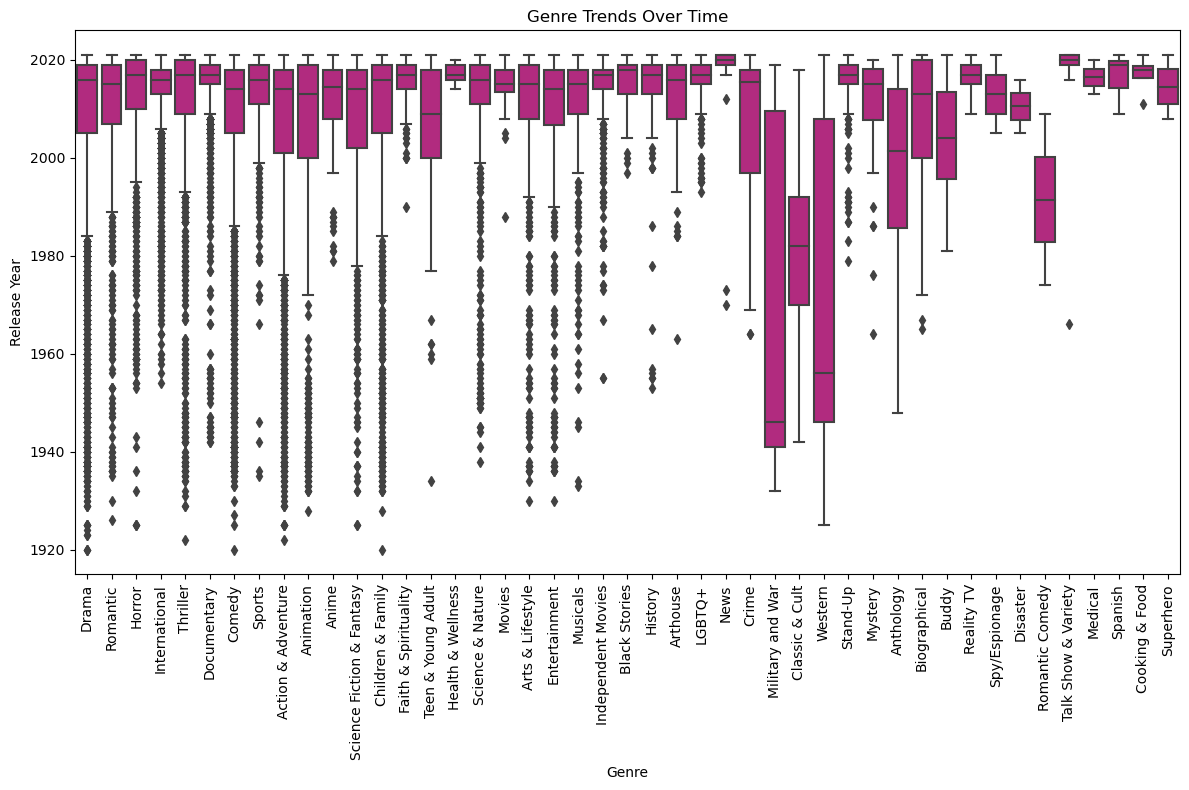

In [14]:
# Genre Trends Over Time
# Box plots to visualize the distribution of release years for each genre
df_split_genres = df.assign(genre=df['genre'].str.split(', ')).explode('genre')
plt.figure(figsize=(12, 8))
sns.boxplot(x='genre', y='release_year', data=df_split_genres, color='mediumvioletred')
plt.title('Genre Trends Over Time')
plt.xlabel('Genre')
plt.ylabel('Release Year')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

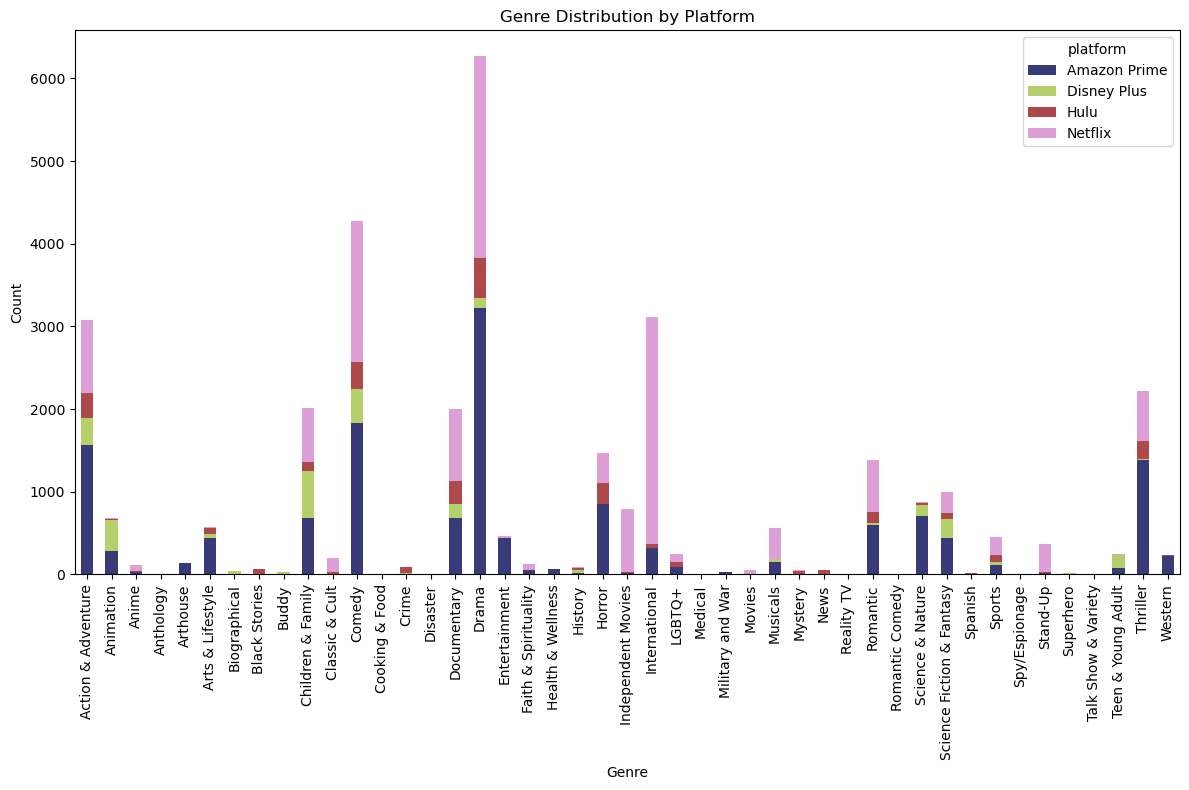

In [15]:
# Genre Distribution by Platform (Stacked Bar Chart)
df_split_platforms = df_split_genres.assign(platform=df_split_genres['platform'].str.split(', ')).explode('platform')

# Create a stacked bar chart for genre distribution by platform
genre_platform_counts = df_split_platforms.groupby(['genre', 'platform']).size().unstack()
genre_platform_counts.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='tab20b')
plt.title('Genre Distribution by Platform')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [16]:
# Genre Combinations
genre_combinations = df['genre'].str.split(', ', expand=True)
has_multiple_genres = genre_combinations.apply(lambda x: x.count() > 1, axis=1)
genre_combinations_with_comma = genre_combinations[has_multiple_genres]
genre_combination_counts = genre_combinations_with_comma.apply(lambda x: ', '.join(x.dropna()), axis=1).value_counts()
top_combinations = genre_combination_counts[genre_combination_counts.index.str.contains(',')].head(10)

print(top_combinations)

Drama, Thriller                             435
Drama, International                        423
Comedy, Drama                               390
Action & Adventure, Drama                   386
Horror, Thriller                            317
Comedy, Drama, International                297
Drama, Independent Movies, International    249
Drama, Romantic                             236
Animation, Children & Family                224
Comedy, International                       206
dtype: int64
